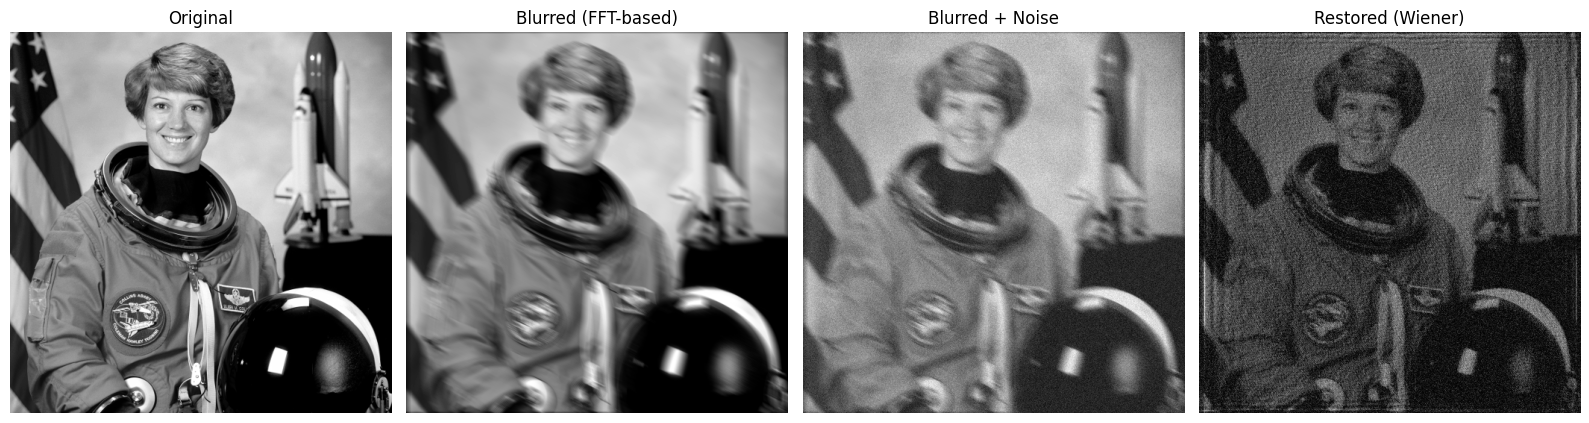

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, data, img_as_float
from scipy.signal import fftconvolve
from numpy.fft import fft2, ifft2, fftshift, ifftshift

# Load example image
image = color.rgb2gray(data.astronaut())
image = img_as_float(image)

# Fast vectorized motion blur PSF
def motion_blur_psf(length, angle, shape):
    psf = np.zeros(shape)
    center = (shape[0] // 2, shape[1] // 2)
    
    # Create coordinates for line
    x = np.linspace(-length//2, length//2, length)
    xx = (center[1] + x * np.cos(np.deg2rad(angle))).astype(int)
    yy = (center[0] + x * np.sin(np.deg2rad(angle))).astype(int)
    
    # Clip indices to stay inside image boundaries
    xx = np.clip(xx, 0, shape[1]-1)
    yy = np.clip(yy, 0, shape[0]-1)
    
    psf[yy, xx] = 1
    psf /= psf.sum()
    return psf

# Generate PSF
psf = motion_blur_psf(length=15, angle=30, shape=image.shape)

# Fast FFT-based convolution (blurring)
blurred = fftconvolve(image, psf, mode='same')

# Calculate OTF (FFT of PSF)
otf = fft2(ifftshift(psf))

# Add Gaussian noise
np.random.seed(0)
noisy = blurred + 0.05 * np.random.standard_normal(image.shape)

# Wiener filter function
def wiener_filter(degraded, otf, K):
    degraded_fft = fft2(degraded)
    otf_conj = np.conj(otf)
    otf_abs2 = np.abs(otf)**2
    wiener_fft = (otf_conj / (otf_abs2 + K)) * degraded_fft
    restored = np.abs(ifft2(wiener_fft))
    return restored

# Apply Wiener filter
K = 0.01  # adjust this depending on noise level
restored = wiener_filter(noisy, otf, K)

# Plot results
fig, axes = plt.subplots(1, 4, figsize=(16, 5))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original")
axes[0].axis('off')

axes[1].imshow(blurred, cmap='gray')
axes[1].set_title("Blurred (FFT-based)")
axes[1].axis('off')

axes[2].imshow(noisy, cmap='gray')
axes[2].set_title("Blurred + Noise")
axes[2].axis('off')

axes[3].imshow(restored, cmap='gray')
axes[3].set_title("Restored (Wiener)")
axes[3].axis('off')

plt.tight_layout()
plt.show()
